In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt 
import duckdb
import shapely.wkb
from shapely.wkb import loads

import glob
import os

from shapely.geometry import Polygon
from shapely import wkt

import seaborn as sns

### Functions

In [ ]:
y = pd.read_csv("table_of_years.csv") # from 'table_of_years.ipynb'
y = y.drop(columns=['Unnamed: 0'])
y['time'] = pd.to_datetime(y['time'], format='%Y-%m')
y['time'] = y['time'].dt.to_period('M')
y = y.loc[(y['year'] >= 2019)]

In [3]:
# All corporate Hashtags
hashtag_list = ['amap', 'adt', 'bolt', 'digitalegypt', 'expedia', 'gojek', 'MSFTOpenMaps', 'grab', 'Kaart', 'Kontur', 'mbx', 'RocketData',
                'disputed_by_claimed_by', 'Snapp', 'stackbox', 'Telenav', 'Lightcyphers', 'tomtom', 'TIDBO', 'WIGeoGIS', 'نشان',
                'mapbox', 'Komoot', 'AppLogica']

### Initial 3 
**Remove later - combi calculation later**

In [4]:
def Edits_monthly_total(country):
    monthly = f"""
        SELECT year, month, COUNT(*) AS totalEdits
        FROM db
        WHERE country = '{country}'
        GROUP BY month, year
        ORDER BY year, month ASC
    """

    result = duckdb.sql(monthly)
    # Convert the result to a pandas DataFrame
    df = result.to_df()

    
    df["time"] = df["year"].astype(str) + '-' + df["month"].astype(str) #creating a new column 'time', combining both month and year
    # adjusting the format of the 'time' column to be able to adjust in the correct order with 'ascending'
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m') 
    df['time'] = df['time'].dt.to_period('M')
    df = df.sort_values(by=['time'], ascending=True) 

    #merging the data to the prepared yf df (see Preperation) which contains the dates for every month 2015 - 2023  
    mergedYear = pd.merge(y, df, how="left", on='time')
    #dropping the doubled columns
    mergedYear = mergedYear.drop(columns=["year_y", "month_y", "year_x", "month_x"])
   
    # the new df will now contain the months and years with no edits as well
    return mergedYear


In [5]:
def Edits_monthly_longterm(where_statement, country, new_column_name):
    # Edits either corporate or non-corporate depending on the where statement
    monthly = f"""
        SELECT year, month, COUNT(*) AS totalEdits
        FROM db
        WHERE ({where_statement}) AND country = '{country}'
        GROUP BY month, year
        ORDER BY year, month ASC
    """

    result = duckdb.sql(monthly)
    # Convert the result to a pandas DataFrame
    df = result.to_df()

    
    df["time"] = df["year"].astype(str) + '-' + df["month"].astype(str) #creating a new column 'time', combining both month and year
    # adjusting the format of the 'time' column to be able to adjust in the correct order with 'ascending'
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m') 
    df['time'] = df['time'].dt.to_period('M')
    df = df.sort_values(by=['time'], ascending=True) 

    #merging the data to the prepared yf df (see Preperation) which contains the dates for every month 2015 - 2023  
    mergedYear = pd.merge(y, df, how="left", on='time')
    #dropping the doubled columns
    mergedYear = mergedYear.drop(columns=["year_y", "month_y", "year_x", "month_x"])
    mergedYear = mergedYear.rename(columns={'totalEdits': new_column_name})
    # the new df will now contain the months and years with no edits as well
    return mergedYear


def combinedTabelAllEdits_longterm(CEwhere_statment, country, nonCEwhere_statment):
    
    CE_edits = Edits_monthly_longterm(CEwhere_statment, country, 'CE')
    nonCE_edits = Edits_monthly_longterm(nonCEwhere_statment, country, 'NCE')
    total_edits = Edits_monthly_total(country)

    mergedYear = pd.merge(nonCE_edits, CE_edits, how="left", on='time')
    mergedYear = pd.merge(mergedYear, total_edits, how="left", on='time')
    return mergedYear


In [6]:
# creating a custom list of hashtags for each coutnry, since not every hashtag is used per country - for overview and speed
def CreateCorporateHashtagList(country):
    hashtagCE = "\n".join([
        f"WHEN hashtags ILIKE '%{hashtag}%' THEN '{hashtag}'" for hashtag in hashtag_list
    ])
    
    # Calculate the percentage of editor users based on the total user count
    t1 = duckdb.sql(f""" 
        SELECT
            CASE
                {hashtagCE}
            END AS hashtag,
            COUNT(*) AS Edits,
        FROM db
        WHERE country = '{country}'
        GROUP BY hashtag
        ORDER BY Edits DESC
        """)
    t1.fetchall()

    t1 = t1.to_df()
    noCE = t1.dropna()
    corporate_list = noCE['hashtag'].tolist()
    return corporate_list

In [7]:
def generate_ce_statement(hashtags_list):
    # Construct the dynamic CE statement based on the list of hashtags
    ce_statement = " OR ".join([f"hashtags ILIKE '%{tag}%'" for tag in hashtags_list])
    return ce_statement

def generate_nonce_statement(hashtags_list):
    # Construct the dynamic nonCE statement based on the list of hashtags
    non_ce_statement = " AND ".join([f"hashtags NOT ILIKE '%{tag}%'" for tag in hashtags_list])
    return non_ce_statement

In [8]:
def download_monthly_edits(country):
    hashtag_list = CreateCorporateHashtagList(country)

    CE_where = generate_ce_statement(hashtag_list)
    non_CE_where = generate_nonce_statement(hashtag_list)

    edits_monthly = combinedTabelAllEdits_longterm(CE_where, country, non_CE_where)

    edits_monthly.to_csv(country + '_edits_monthly_total_ce_nce.csv', header = True)

In [9]:
#data files
db = duckdb.read_parquet(r"D:\Datenbank\ohsome-stats-yearly\year=*\month=*\*.parquet", hive_partitioning=1) 

#### Meta Extras

In [10]:
# Specify the directory where your Excel files are located
directory_path =  r"C:\Users\lilly\Documents\bachelorarbeit\analysis\UserNameID-v2"

# Get a list of all Excel files in the directory
excel_files = glob.glob(os.path.join(directory_path, "*.xls"))

# Create an empty dictionary to store DataFrames
dataframes_dict = {}

# Read each Excel file and store its DataFrame in the dictionary - files saved as xldr - otherwise when saved as csv, other method applicable
for excel_file in excel_files:
    filename = os.path.basename(excel_file)
    df = pd.read_csv(excel_file) 
    dataframes_dict[filename] = df

In [11]:
# get the user-ids in working format
def getListID(filename):
    df = dataframes_dict[filename]
    CorpoId = df['User ID']
    user_ids_str = ','.join([f"'{id}'" for id in CorpoId])
    return user_ids_str

In [12]:
Meta = getListID("MetaUser.xls")

In [13]:
def meta_ce_where():
    # Construct the dynamic CE statement based on the list of hashtags
    ce_statement = f"user_id IN ({Meta})"
    return ce_statement

In [14]:
add_on_meta_ce_where = meta_ce_where()

In [15]:
def meta_download(country):
    CE_edits = Edits_monthly_longterm(add_on_meta_ce_where, country, 'Meta')
    CE_edits.to_csv(country + '_edits_monthly_meta.csv', header = True)
    

## Combi for additional coutnries

In [16]:
def Edits_monthly_total_combi(country):
    monthly = f"""
        SELECT year, month, COUNT(*) AS totalEdits
        FROM db
        WHERE country = '{country}' AND year > 2018
        GROUP BY month, year
        ORDER BY year, month ASC
    """

    result = duckdb.sql(monthly)
    # Convert the result to a pandas DataFrame
    df = result.to_df()

    
    df["time"] = df["year"].astype(str) + '-' + df["month"].astype(str) #creating a new column 'time', combining both month and year
    # adjusting the format of the 'time' column to be able to adjust in the correct order with 'ascending'
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m') 
    df['time'] = df['time'].dt.to_period('M')
    df = df.sort_values(by=['time'], ascending=True) 

    #merging the data to the prepared yf df (see Preperation) which contains the dates for every month 2015 - 2023  
    mergedYear = pd.merge(y, df, how="left", on='time')
    #dropping the doubled columns
    mergedYear = mergedYear.drop(columns=["year_y", "month_y", "year_x", "month_x"])
   
    # the new df will now contain the months and years with no edits as well
    return mergedYear


In [17]:
def Edits_monthly_longterm_combi(where_statement, country, new_column_name):
    # Edits either corporate or non-corporate depending on the where statement
    monthly = f"""
        SELECT year, month, COUNT(*) AS totalEdits
        FROM db
        WHERE ({where_statement}) AND country = '{country}' AND year > 2018
        GROUP BY month, year
        ORDER BY year, month ASC
    """

    result = duckdb.sql(monthly)
    # Convert the result to a pandas DataFrame
    df = result.to_df()

    
    df["time"] = df["year"].astype(str) + '-' + df["month"].astype(str) #creating a new column 'time', combining both month and year
    # adjusting the format of the 'time' column to be able to adjust in the correct order with 'ascending'
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m') 
    df['time'] = df['time'].dt.to_period('M')
    df = df.sort_values(by=['time'], ascending=True) 

    #merging the data to the prepared yf df (see Preperation) which contains the dates for every month 2015 - 2023  
    mergedYear = pd.merge(y, df, how="left", on='time')
    #dropping the doubled columns
    mergedYear = mergedYear.drop(columns=["year_y", "month_y", "year_x", "month_x"])
    mergedYear = mergedYear.rename(columns={'totalEdits': new_column_name})
    # the new df will now contain the months and years with no edits as well
    return mergedYear


def combinedTabelAllEdits_longterm_combi(CEwhere_statment, country, nonCEwhere_statment):
    
    CE_edits = Edits_monthly_longterm_combi(CEwhere_statment, country, 'CE')
    nonCE_edits = Edits_monthly_longterm_combi(nonCEwhere_statment, country, 'NCE')
    total_edits = Edits_monthly_total_combi(country)

    mergedYear = pd.merge(nonCE_edits, CE_edits, how="left", on='time')
    mergedYear = pd.merge(mergedYear, total_edits, how="left", on='time')
    return mergedYear


In [18]:
def generate_ce_statement_combi(hashtags_list):
    # Construct the dynamic CE statement based on the list of hashtags
    ce_statement = " OR ".join([f"hashtags ILIKE '%{tag}%'" for tag in hashtags_list]) + f"OR user_id IN ({Meta})"
    return ce_statement

def generate_nonce_statement_combi(hashtags_list):
    # Construct the dynamic nonCE statement based on the list of hashtags
    non_ce_statement = " AND ".join([f"hashtags NOT ILIKE '%{tag}%'" for tag in hashtags_list]) + f"AND user_id NOT IN ({Meta})"
    return non_ce_statement

In [19]:
def download_monthly_edits_combi(country):
    hashtag_list = CreateCorporateHashtagList(country)

    CE_where = generate_ce_statement_combi(hashtag_list)
    non_CE_where = generate_nonce_statement_combi(hashtag_list)

    edits_monthly = combinedTabelAllEdits_longterm_combi(CE_where, country, non_CE_where)

    edits_monthly['percentage'] = (edits_monthly['CE'] / edits_monthly['totalEdits']) * 100

    edits_monthly.to_csv(country + '_edits_monthly_total_ce_nce.csv', header = True)

# Initial 3
**add later to the rest of the countries**

### UNITED ARAB EMIRATES

In [14]:
download_monthly_edits('ARE')

In [11]:
are_edits_monthly = pd.read_csv('are_edits_monthly_ce_nce.csv')

In [39]:
are_edits_monthly_complete = pd.read_csv('are_edits_monthly_total_ce_nce.csv')

**Meta add on**

In [41]:
meta_download('ARE')

In [38]:
are_meat_t1 = are_meat_t1.fillna(0)

### COLOMBIA

In [17]:
download_monthly_edits('COL')

In [20]:
col_edits_monthly = pd.read_csv('COL_edits_monthly_total_ce_nce.csv')

<Axes: xlabel='time'>

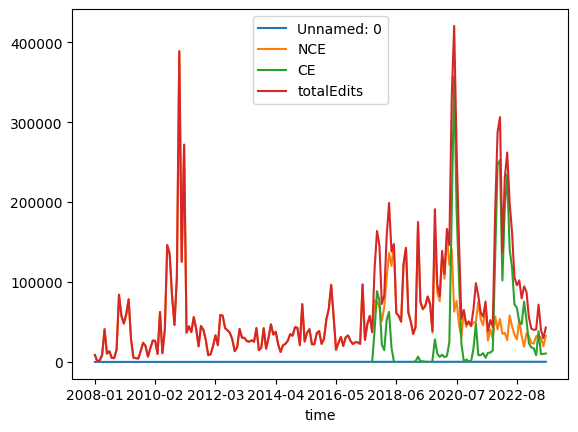

In [21]:
col_edits_monthly.plot(x = 'time')

**Meta add on**

In [42]:
meta_download('COL')

In [55]:
col_edits_monthly_meta = pd.read_csv('COL_edits_monthly_meta.csv')

In [56]:
col_edits_monthly_meta['Meta'].dropna().sum()

2759.0

### INDONESIA

In [22]:
download_monthly_edits('IDN')

**Meta add on**

In [43]:
meta_download('IDN')

In [2]:
idn_edits_monthly_meta = pd.read_csv('IDN_edits_monthly_meta.csv')

In [4]:
idn_edits_monthly = pd.read_csv('IDN_edits_monthly_total_ce_nce.csv')

# Additional Countries

In [20]:
#uruguay
download_monthly_edits_combi('URY')

In [21]:
#Greece
download_monthly_edits_combi('GRC')

In [22]:
#Bahrain
download_monthly_edits_combi('BHR')

In [23]:
#Qatar
download_monthly_edits_combi('QAT')

In [24]:
#Greece
download_monthly_edits_combi('CHL')

In [25]:
#Greece
download_monthly_edits_combi('MYS')

In [27]:
#VNM
download_monthly_edits_combi('VNM')

In [28]:
download_monthly_edits_combi('DOM')

In [29]:
download_monthly_edits_combi('OMN')

In [30]:
download_monthly_edits_combi('KWT')

In [32]:
download_monthly_edits_combi('ECU')

In [33]:
download_monthly_edits_combi('SGP')

In [34]:
download_monthly_edits_combi('KHM')

In [35]:
download_monthly_edits_combi('MUS')

In [36]:
download_monthly_edits_combi('CYP')

In [37]:
download_monthly_edits_combi('MMR')

In [40]:
download_monthly_edits_combi('ZAF')

In [38]:
download_monthly_edits_combi('MLT')

In [41]:
download_monthly_edits_combi('VEN')

In [42]:
download_monthly_edits_combi('PHL')

In [43]:
download_monthly_edits_combi('PAK')

In [44]:
download_monthly_edits_combi('TZA')

In [45]:
download_monthly_edits_combi('BRA')

In [46]:
download_monthly_edits_combi('KWT')

In [47]:
download_monthly_edits_combi('IND')

In [48]:
download_monthly_edits_combi('MEX')